# 08.02 Noise Reduction

We did see that white noise has linear relations.
And since PCA is a linear technique it is perfect to operate on noise.
Moreover, white noise has low variance, hence if we reduce
the dimensions according to variance in decreasing order
(as PCA does) we will de-noise the image.

Let's import PCA and a loader for a dataset.
And using these we will push our PCA use by a notch.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-talk')
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_lfw_people

![Bush](ul-bush.svg)

<div style="text-align:right;"><sup>ul-bush.svg</sup></div>

When used on faces,
and since eigenvectors have been used on faces over the years in many applications,
the eigenvectors are called by some people *eigenfaces*.
The eigenfaces represent the biggest directions of variations across a dataset of faces,
and are a common preprocessing technique in face recognition,
i.e. to reduce the image noise before attempting the classification.
Eventually we will build a face classifier but for now we will
focus in the noise removal.

To get some faces we will use the *Labeled Faces in the Wild* (lfw) dataset,
which contains thousands of cropped photos to show only the face.
This dataset has been produced in early $2000$s, therefore has mostly people often photographed at that time.
It may take a short while while `sklearn` downloads the images.

In [2]:
faces = fetch_lfw_people(min_faces_per_person=30)
print(faces.target_names)
faces.images.shape, faces.data.shape

['Alejandro Toledo' 'Alvaro Uribe' 'Andre Agassi' 'Ariel Sharon'
 'Arnold Schwarzenegger' 'Colin Powell' 'David Beckham' 'Donald Rumsfeld'
 'George W Bush' 'Gerhard Schroeder' 'Gloria Macapagal Arroyo'
 'Guillermo Coria' 'Hans Blix' 'Hugo Chavez' 'Jacques Chirac'
 'Jean Chretien' 'Jennifer Capriati' 'John Ashcroft' 'John Negroponte'
 'Junichiro Koizumi' 'Kofi Annan' 'Laura Bush' 'Lleyton Hewitt'
 'Luiz Inacio Lula da Silva' 'Megawati Sukarnoputri' 'Nestor Kirchner'
 'Recep Tayyip Erdogan' 'Roh Moo-hyun' 'Serena Williams'
 'Silvio Berlusconi' 'Tom Ridge' 'Tony Blair' 'Vicente Fox'
 'Vladimir Putin']


((2370, 62, 47), (2370, 2914))

We asked for people from the dataset which have at least $30$ face images,
And we got a reasonable set of people.

Every image is $62$ by $47$ pixels, or $2914$ pixels in total.
We argue that we have $2914$ different features.
In other words, every pixel in the image is a feature.
The first feature (column) is the first pixel *in every image*,
the second feature is the second pixel in every image, and so on.
`matplotlib` provides us with `imshow`,
since we are working with images, this is perfect to see what we are working with.
We reshape the sample (row) into the number of pixel rows we know the image has
but in our dataset every image is just a long string of $2914$ pixels/features.

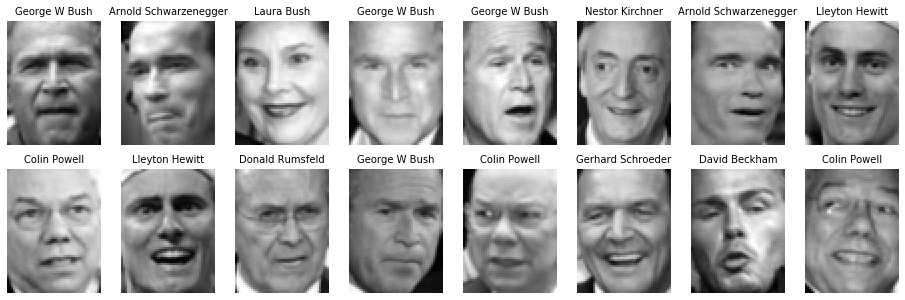

In [3]:
fig, axes = plt.subplots(2, 8, figsize=(16, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i, ax in enumerate(axes.flat):
    ax.imshow(faces.data[i].reshape(62, 47), cmap='gray')
    ax.set_title(faces.target_names[faces.target[i]], fontsize=10)
    ax.axis('off')

A rule of thumb is that, for images, $2 \cdot \sqrt N$,
where $N$ is the number of pixels (i.e. features),
is a good number of reduced features.
We will use $128$, since it is close to the square root of $2914$ and is a power of $2$.
Remember that PCA `components_` is the transformation matrix, the eigenvectors.
The `explained_variance_` are the vector magnitudes,
without the scaling that we saw in `explained_variance_ratio_`.

We will use a *randomized* solver for this dataset.
The randomized solver uses a heuristic method to identify the first couple of eigenvectors.
Solving the decomposition problem is very costly for big datasets,
the randomized solver alleviates this considerably.

In [4]:
pca = PCA(n_components=128, svd_solver='randomized')
pca.fit(faces.data)
pca.components_, pca.components_.shape, pca.explained_variance_

(array([[-5.7818759e-03, -6.4754006e-03, -7.5026783e-03, ...,
         -7.5029097e-03, -6.3219899e-03, -5.4036044e-03],
        [ 1.5533447e-02,  1.4904640e-02,  1.5029914e-02, ...,
         -3.5391297e-02, -3.4057703e-02, -3.2458935e-02],
        [ 4.3386981e-02,  4.4438511e-02,  4.5924850e-02, ...,
          2.2555584e-02,  2.0741794e-02,  1.8328616e-02],
        ...,
        [ 6.6613056e-02,  6.0947821e-02,  2.3687277e-02, ...,
         -1.9117665e-02, -5.8753639e-03,  1.8420188e-02],
        [-2.5263116e-02, -2.0417694e-02,  5.8451667e-05, ...,
         -4.1156106e-02,  1.0173069e-02,  3.9984766e-02],
        [ 4.9191792e-02,  2.9570796e-02, -1.6778447e-02, ...,
          1.4203662e-02,  2.9270684e-02,  3.4176975e-02]], dtype=float32),
 (128, 2914),
 array([982217.44  , 581732.7   , 328734.66  , 298409.47  , 197671.34  ,
        137052.66  ,  97544.21  ,  86715.766 ,  83362.836 ,  74749.16  ,
         72634.695 ,  64542.84  ,  58063.75  ,  50905.605 ,  49381.094 ,
         44700.37

This time the transformation matrix is quite big,
$2914$ rows and $128$ columns to be exact.
We have this many eigenvectors because our dataset
has $2914$ features instead of the $3$ we saw before.
The images may seem two dimensional for us but
in order to get more out of the images than just the
pixel histograms on each side we need to understand the
images with each pixel/dataset column/feature as a single dimension.

We can also see how the eigenvectors actually look on the images.
We can display images of $2914$ features/pixels,
the eigenvectors have exactly the same number of dimensions so we can plot them the same way.

We plot the eigenvectors/eigenfaces in order of explained variance,
from the eigenvector that explains the most in descending order.

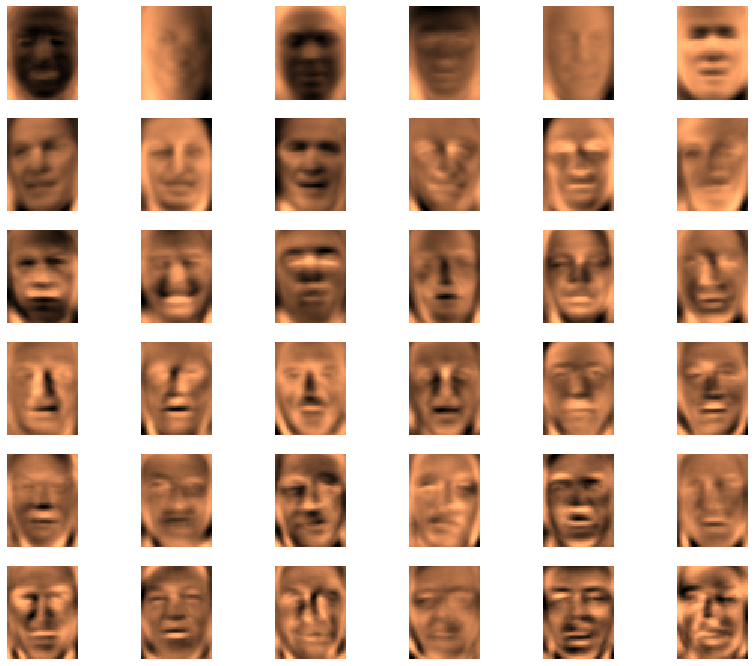

In [5]:
fig, axes = plt.subplots(6, 6, figsize=(14, 12))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='copper')
    ax.axis('off')

The most important eigenvectors are changes
in illumination and orientation of the face.
At first sight we may argue that that would be a problem if we would try to build a classifier.
By the contrary, the PCA managed to move (most of) the illumination and orientation
into their own dimensions, which means they were removed from the other dimensions.
We could tweak the PCA output to prevent the first eigenvectors from being used.
Yet, that's a topic for another time.

We saw that we order the eigenvectors in explained variance order.
But how much variance each eigenvector explains?
We often want to plot a cumulative explained variance,
to understand how many components we actually need.
Let's rebuild the PCA with $512$ components
(we have no need to build all $2914$ eigenvectors)
and evaluate whether our choice of $128$ components was good.

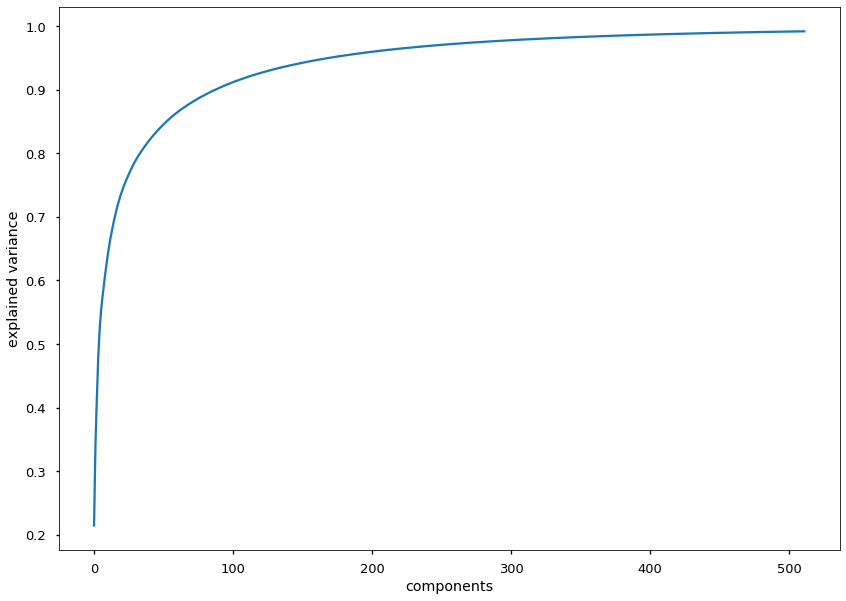

In [6]:
pca = PCA(n_components=512, svd_solver='randomized')
pca.fit(faces.data)
fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set(xlabel='components', ylabel='explained variance');

The `transform` of the PCA technique projects the data into the space defined by the eigenvectors.
This operation *loses some information* but since the majority
of the variance is retained the loss is as minimal as possible.
Our choice of $128$ is quite reasonable as by then more than $90\%$
of the variance is accounted for.

The `inverse_transform` can throw the projection back into the original dimensions,
yet the data loss remains since we cannot guess that data.
This, plus the fact that the images are easy to evaluate by the human eye,
allows us to visualize how much data was actually lost.
For comparison let us build a PCA projecting onto
$128$ dimensions and one projecting onto $256$ dimensions.

In [7]:
proj = {}
for i in [128, 256]:
    pca = PCA(n_components=i, svd_solver='randomized')
    pca.fit(faces.data)
    reduced = pca.transform(faces.data)
    proj[i] = pca.inverse_transform(reduced)

And after that we also performed the inverse transformation.
The inverse transformation did project the images back into $2914$ dimensions.

In [8]:
proj[128].shape, proj[256].shape

((2370, 2914), (2370, 2914))

Since $2914$ can be understood as an image of $62$ by $47$ we can now plot
as an image the inverse transformed projections.

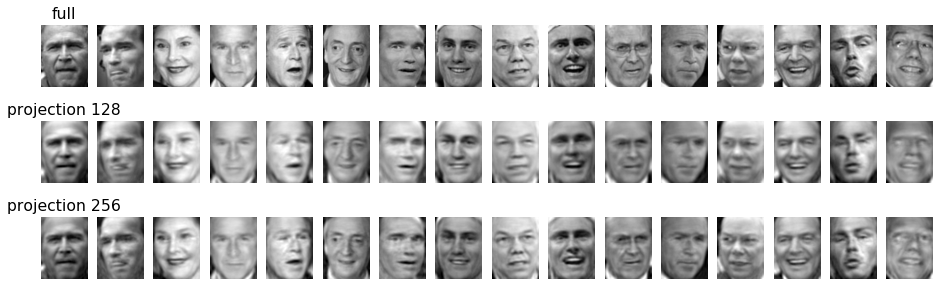

In [9]:
fig, ax = plt.subplots(3, 16, figsize=(16, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i in range(16):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='gray')
    ax[1, i].imshow(proj[128][i].reshape(62, 47), cmap='gray')
    ax[2, i].imshow(proj[256][i].reshape(62, 47), cmap='gray')
for img in ax.flat:
    img.axis('off')
ax[0, 0].set_title('full')
ax[1, 0].set_title('projection 128');
ax[2, 0].set_title('projection 256');

We can now visually inspect the data loss.
It is possible to argue that once can still recognize the faces in both projections.
Moreover, in the projections the images are smoother, and indication of de-noising.

For a classifier the same applies.
As we can still identify faces so can a classifier.
And without the noise such a classifier would be less likely to
get stuck in some unimportant noisy details and would look at the general picture.
Less features (dimensions) as in the not inverse transformed projections
also mean fewer numbers to process for each sample,
resulting in a quicker fit time for such a classifier.

## References

- [SciKit Learn - Face Decomposition][1]
- [SciKit Learn - Face Recognition][2]

[1]: https://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html
[2]: https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html